# APS - Mineração de Dados

## Descrição

A ideia do projeto é realizar mineração em textos em resumos de artigos da área de conehcimento Ciências da Computação, identificar os principais tópicos e analisar a evolução temporal, buscando entende como as áreas se relacionam entre si.

### Dados

- Os dados utilizados são da API do Arxv que é um site onde existe um repositório de artigos cientifícos. 
- Serão utilziados dados da área de conhecimento da computação, foram escolhidas 3 subcategorias, Inteligência Artificial, Information Retrival e Machine Learning. 
- Os dados disponíveis na API estão tabulados, e as colunas são: ID, Updated, Published, Title, Summary, Authors, Categories.


### Modelo

- O modelo utilizado para modelagem de tópicos é o modelo de neural BERTopic. 

### Análise

- Principais tópicos de cada categoria.
- Evolução temporal dos Tópicos.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import random

# NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


#BERTopic
from bertopic import BERTopic

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigochavoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/rodrigochavoni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [92]:
# Carrega os dataset que serão utilizados, e cria um com todas as categorias juntas
df_AI = pd.read_csv('data/cs.AI.csv').sample(1500)
df_ML = pd.read_csv('data/cs.LG.csv').simple(1500)
df_IR = pd.read_csv('data/cs.IR.csv').simple(2000)
df_todos = pd.concat([df_AI, df_ML, df_IR], axis=0)

df_todos = df_todos[df_todos['Published'] >= '2012-01-01']

# Converte a coluna Published para datetime
df_AI['Published'] = pd.to_datetime(df_AI['Published'])
df_ML['Published'] = pd.to_datetime(df_ML['Published'])
df_IR['Published'] = pd.to_datetime(df_IR['Published'])
df_todos['Published'] = pd.to_datetime(df_todos['Published'])

# Cria lista com os timestamps e abstracts de cada dataset
ai_timestamps = df_AI.Published.to_list()
ml_timestamps = df_ML.Published.to_list()
ir_timestamps = df_IR.Published.to_list()
todos_timestamps = df_todos.Published.to_list()

ai_timestampsai_abstract = df_AI.Summary.to_list()
ml_abstract = df_ML.Summary.to_list()
ir_abstract = df_IR.Summary.to_list()
todos_abstract = df_todos.Summary.to_list()

In [93]:
def to_mes_anos(lista):
    lista_data = []    
    for i in lista:    
        lista_dados = i.strftime('%Y-%m-%d')
        lista_data.append(lista_dados)
    return lista_data


# ai_timestamps = to_mes_anos(ai_timestamps)
# ml_timestamps = to_mes_anos(ml_timestamps)
# ir_timestamps = to_mes_anos(ir_timestamps)
todos_timestamps = to_mes_anos(todos_timestamps)

In [94]:
# Apresentação dos dados
def show_data_info(data: pd.DataFrame):
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.values}")
    print("Sample:")
    display(data.head())

show_data_info(df_todos)

Shape: (3000, 7)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories
2692,http://arxiv.org/abs/2208.09577v2,2022-11-08T03:49:46Z,2022-08-20 02:00:16+00:00,Real-time Short Video Recommendation on Mobile...,Short video applications have attracted bill...,"Xudong Gong, Qinlin Feng, Yuan Zhang, Jianglin...",cs.IR
8655,http://arxiv.org/abs/2307.15142v1,2023-07-27T18:37:49Z,2023-07-27 18:37:49+00:00,Reconciling the accuracy-diversity trade-off i...,"In recommendation settings, there is an appa...","Kenny Peng, Manish Raghavan, Emma Pierson, Jon...","cs.IR, cs.SI"
437,http://arxiv.org/abs/1302.2157v2,2013-05-19T00:39:52Z,2013-02-08 21:18:24+00:00,Passive Learning with Target Risk,In this paper we consider learning in passiv...,"Mehrdad Mahdavi, Rong Jin",cs.LG
2445,http://arxiv.org/abs/1304.5897v1,2013-04-22T09:54:07Z,2013-04-22 09:54:07+00:00,Towards an Extension of the 2-tuple Linguistic...,"In the domain of Computing with words (CW), ...","Mohammed-Amine Abchir, Isis Truck",cs.AI
7264,http://arxiv.org/abs/2112.02989v1,2021-12-06T13:08:53Z,2021-12-06 13:08:53+00:00,On the complexity of Dark Chinese Chess,This paper provides a complexity analysis fo...,"Cong Wang, Tongwei Lu",cs.AI


## Média de Palavras

In [95]:
df_todos['length'] = df_todos.Summary.apply(lambda row: len(row.split()))
print('Mean length: ', df_todos['length'].mean())

Mean length:  164.756


<Axes: xlabel='length', ylabel='Density'>

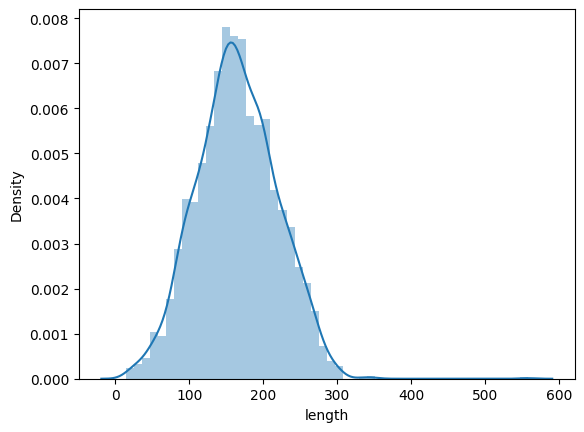

In [96]:
sns.distplot(df_todos['length'])

## BERTopic

In [97]:
stopwords = stopwords.words('english')
vec_model = CountVectorizer(stop_words=stopwords)

In [98]:
def Bert_topic_model(vec_model: CountVectorizer):
    topic_model = BERTopic(embedding_model='all-MiniLM-L6-v2', 
                    verbose=True,
                    vectorizer_model=vec_model,
                    low_memory=True,
                    calculate_probabilities=True,
                    n_gram_range=(1, 3))

    return topic_model

# ia_topic_model = Bert_topic_model(vec_model)
# ml_topic_model = Bert_topic_model(vec_model)
# ir_topic_model = Bert_topic_model(vec_model)
todos_topic_model = Bert_topic_model(vec_model)

# ai_topics, ai_probs = ia_topic_model.fit_transform(df_AI['Summary'])
# ml_topics, ml_probs = ml_topic_model.fit_transform(df_ML['Summary'])
# ir_topics, ir_probs = ir_topic_model.fit_transform(df_IR['Summary'])
todos_topics, todos_probs = todos_topic_model.fit_transform(df_todos['Summary'])

2024-06-16 23:21:53,647 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 94/94 [04:30<00:00,  2.87s/it]
2024-06-16 23:26:25,695 - BERTopic - Embedding - Completed ✓
2024-06-16 23:26:25,700 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-16 23:26:39,871 - BERTopic - Dimensionality - Completed ✓
2024-06-16 23:26:39,875 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-16 23:26:40,161 - BERTopic - Cluster - Completed ✓
2024-06-16 23:26:40,172 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-16 23:26:40,820 - BERTopic - Representation - Completed ✓


In [99]:
todos_topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,628,-1_learning_data_model_based,"[learning, data, model, based, approach, probl...",[ In order to deal with the high development ...
1,0,1077,0_user_recommendation_information_users,"[user, recommendation, information, users, ret...",[ Personalized search plays a crucial role in...
2,1,134,1_training_neural_networks_deep,"[training, neural, networks, deep, network, gr...",[ Modern neural network architectures for lar...
3,2,120,2_graph_node_graphs_gnns,"[graph, node, graphs, gnns, networks, learning...","[ In recent years, graph neural networks (GNN..."
4,3,98,3_data_patients_model_clinical,"[data, patients, model, clinical, medical, pat...",[ Mortality prediction in intensive care unit...
5,4,93,4_ai_intelligence_artificial_human,"[ai, intelligence, artificial, human, explanat...","[ This paper summarises how the ""SP theory of..."
6,5,53,5_bayesian_networks_inference_network,"[bayesian, networks, inference, network, belie...",[ The EM-algorithm is a general procedure to ...
7,6,50,6_federated_fl_clients_privacy,"[federated, fl, clients, privacy, local, data,...",[ Conventional federated learning (FL) trains...
8,7,43,7_adversarial_attacks_robustness_attack,"[adversarial, attacks, robustness, attack, exa...","[ In spite of intense research efforts, deep ..."
9,8,41,8_policy_actor_critic_function,"[policy, actor, critic, function, learning, gr...",[ Actor-critic algorithms learn an explicit p...


In [107]:
todos_topic_model.visualize_topics()

In [101]:
topics_over_time = todos_topic_model.topics_over_time(todos_abstract, todos_timestamps, datetime_format="%Y-%m-%d",nr_bins=20)

20it [00:01, 14.91it/s]


In [102]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"knowledge, operators, credal, based, onmf",16,2011-12-30 17:12:28.800
1,0,"web, documents, users, information, text",23,2011-12-30 17:12:28.800
2,2,"directed, networks, link, consensus, fan",2,2011-12-30 17:12:28.800
3,3,"biometric, walker, data, j48, activities",3,2011-12-30 17:12:28.800
4,4,"comet, cognition, simulated, implemented, comp...",1,2011-12-30 17:12:28.800
...,...,...,...,...
426,26,"ood, covariate, shifts, shift, detection",1,2023-02-23 20:24:00.000
427,29,"betazero, pomdps, observable, partially, appro...",1,2023-02-23 20:24:00.000
428,31,"badminton, strokes, rallies, coachai, shuttles...",2,2023-02-23 20:24:00.000
429,35,"fastdiag, constraint, checks, consistency, alg...",1,2023-02-23 20:24:00.000


In [103]:
todos_topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4])

In [104]:
lista_topic = [0,1,2,3,4]
topics_over_time = topics_over_time[topics_over_time['Topic'].isin(lista_topic)]

In [105]:

topics_over_time

,Topic,Words,Frequency,Timestamp,Name
1,0,"web, documents, users, information, text",23,2011-12-30 17:12:28.800,0_user_recommendation_information_users
2,2,"directed, networks, link, consensus, fan",2,2011-12-30 17:12:28.800,2_graph_node_graphs_gnns
3,3,"biometric, walker, data, j48, activities",3,2011-12-30 17:12:28.800,3_data_patients_model_clinical
4,4,"comet, cognition, simulated, implemented, comp...",1,2011-12-30 17:12:28.800,4_ai_intelligence_artificial_human
17,0,"query, information, user, users, web",25,2012-08-05 03:36:00.000,0_user_recommendation_information_users
...,...,...,...,...,...
408,0,"user, recommendation, recommender, retrieval, ...",104,2023-02-23 20:24:00.000,0_user_recommendation_information_users
409,1,"complexity, domain, extrinsic, independent, world",1,2023-02-23 20:24:00.000,1_training_neural_networks_deep
410,2,"node, prostate, graph, cancer, graphs",3,2023-02-23 20:24:00.000,2_graph_node_graphs_gnns
411,3,"prescdrl, patient, treatment, tcm, medical",3,2023-02-23 20:24:00.000,3_data_patients_model_clinical


In [106]:
topic_model.get_document_info(df_todos['Summary'])

NameError: name 'topic_model' is not defined

In [ ]:
df_result = topic_model.get_topic_info()
df_result['Count'].sum()

4500

In [ ]:
topic_model.visualize_barchart()

In [ ]:
def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic"+" "+ str(topic))
    plt.show()

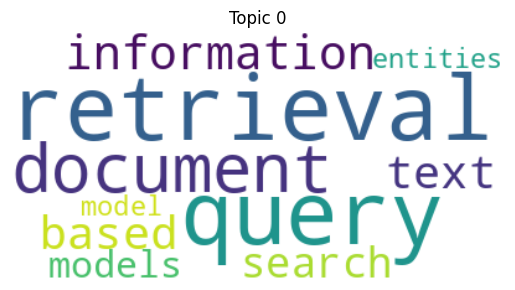

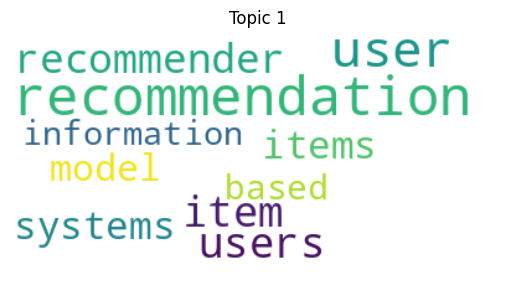

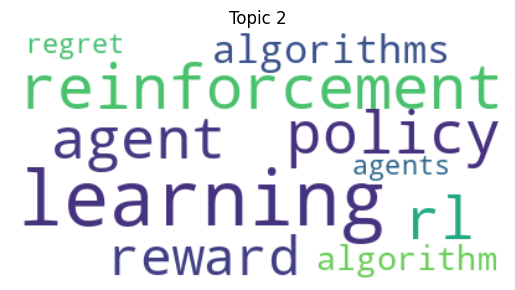

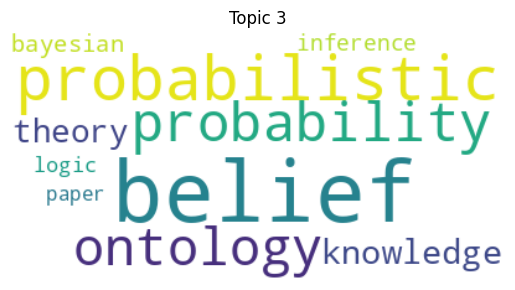

In [ ]:
for i in range(0,4):
    create_wordcloud(todos_topic_model, topic=i)